# Resamplingに関するデータ観察

In [109]:
from datetime import datetime
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from util.preprocess.csi import linear_interpolate_resampling
from util.preprocess.handle_session_data import convert_jst_to_utc, load_meta_data, get_session_data

In [58]:
def filter_by_mac(df, target_mac_addr):
    return df[(df['mac_addr'] == target_mac_addr)]

def filter_by_sig_mode(df, target_sig_mode):
    return df[(df['sig_mode'] == target_sig_mode)]

In [86]:
def validation_csi_data(df):
    # 'csi_data' の処理
    df.loc[:, 'csi_data'] = df['csi_data'].str.strip('[]').str.split()
    df.loc[:, 'csi_data'] = df['csi_data'].apply(lambda x: [int(i) for i in x] if len(x) == 128 else None)
    df = df.dropna(subset=['csi_data'])

    return df[['csi_data', 'timestamp']]

In [37]:
def calc_subcarrier_data(row):
    data = (
        [row['timestamp']] +
        # real parts
        [row['csi_data'][2 * i] for i in range(64)] +  
        # imag parts
        [row['csi_data'][2 * i + 1] for i in range(64)] +  
        # amplitude
        [np.sqrt(row['csi_data'][2 * i]**2 + row['csi_data'][2 * i + 1]**2) for i in range(64)] + 
        # phase
        [np.arctan2(row['csi_data'][2 * i + 1], row['csi_data'][2 * i]) for i in range(64)] 
    )

    return data

In [125]:
def process(df):

    # MACアドレスと802.11nでフィルタリング
    df = filter_by_mac(df, '08:D1:F9:34:A5:98')
    df = filter_by_sig_mode(df, 1)

    df = validation_csi_data(df)
    
    # MultiIndex の列名を作成
    columns = [
        ('timestamp', ''), 
        *[(f'real', f'sc_{i}') for i in range(64)], 
        *[(f'imag', f'sc_{i}') for i in range(64)], 
        *[(f'amp', f'sc_{i}') for i in range(64)], 
        *[(f'phase', f'sc_{i}') for i in range(64)]
    ]
    
    # 各サブキャリアの値を計算して DataFrame に追加
    data = [calc_subcarrier_data(row) for _, row in df.iterrows()]
    
    # MultiIndex を持つ DataFrame を作成
    df = pd.DataFrame(data, columns=pd.MultiIndex.from_tuples(columns))

    return df

In [56]:
def get_session(session_df, i):
    row = session_df.iloc[i]
    session_id = row['session_id']
    location = row['location']
    start_time_jst_str = row['start_time_JST']
    end_time_jst_str = row['end_time_JST']

    start_time_jst = datetime.strptime(start_time_jst_str, '%Y-%m-%d %H:%M:%S')
    end_time_jst = datetime.strptime(end_time_jst_str, '%Y-%m-%d %H:%M:%S')
    print(f"Session ID: {session_id}, Location: {location}, Start Time: {start_time_jst}, End Time: {end_time_jst}")

    return session_id, location, start_time_jst, end_time_jst

In [52]:
def get_csi_data_df(session_id, location):
    session_dirpath = raw_data_dirpath / location / session_id 
    csi_data_filepath = session_dirpath / f'csi_{session_id}.csv'
    df = pd.read_csv(csi_data_filepath)
    df['timestamp'] = pd.to_datetime(pd.to_numeric(df['timestamp'], errors='coerce'), unit='s')
    df['sig_mode'] = pd.to_numeric(df['sig_mode'], errors='coerce')

    return df

In [14]:
root_data_dirpath = Path('/tf/nas/data')
raw_data_dirpath = root_data_dirpath / 'raw'
session_data_filepath = raw_data_dirpath / 'session.csv'
session_df = pd.read_csv(session_data_filepath)

In [16]:
session_df

,session_id,location,start_time_JST,end_time_JST
0,session_20240926_151603,512,2024-09-26 15:17:00,2024-09-26 15:22:00
1,session_20240926_152330,512,2024-09-26 15:24:00,2024-09-26 15:29:00
2,session_20240926_153446,512,2024-09-26 15:35:00,2024-09-26 15:40:00
3,session_20240926_154624,512,2024-09-26 15:47:00,2024-09-26 15:52:00
4,session_20240926_165118,511,2024-09-26 16:52:00,2024-09-26 16:57:00
5,session_20240926_170021,511,2024-09-26 17:01:00,2024-09-26 17:06:00
6,session_20240926_171232,511,2024-09-26 17:13:00,2024-09-26 17:18:00
7,session_20240926_172237,511,2024-09-26 17:23:00,2024-09-26 17:28:00
8,session_20240926_175737,514B,2024-09-26 17:58:00,2024-09-26 18:03:00
9,session_20240926_180441,514B,2024-09-26 18:05:00,2024-09-26 18:10:00


In [148]:
len(session_df)

12

In [311]:
session_id, location, start_time_jst, end_time_jst = get_session(session_df, 8)

Session ID: session_20240926_175737, Location: 514B, Start Time: 2024-09-26 17:58:00, End Time: 2024-09-26 18:03:00


In [312]:
csi_data_df = get_csi_data_df(session_id, location)

In [313]:
df = process(csi_data_df)

In [342]:
csi_data_df

,type,role,mac_addr,rssi,rate,sig_mode,mcs_index,bandwidth,smoothing,not_sounding,...,secondary_channel,local_timestamp,ant,sig_len,rx_state,real_time_set,real_timestamp,len,csi_data,timestamp
0,CSI_DATA,AP,08:D1:F9:34:A5:98,-22,11,1.0,3,1,1,1,...,1,495865090,0,84,0,0,496.018,384,[84 -64 4 0 0 0 0 0 0 0 0 0 22 14 20 14 21 15 ...,2024-09-26 08:57:37.261820160
1,CSI_DATA,AP,08:D1:F9:34:A5:98,-22,11,1.0,4,1,1,1,...,1,495873663,0,84,0,0,496.027,384,[84 -64 4 0 0 0 0 0 0 0 0 0 18 19 17 18 18 20 ...,2024-09-26 08:57:37.270324992
2,CSI_DATA,AP,08:D1:F9:34:A5:98,-22,11,1.0,3,1,1,1,...,1,495891504,0,84,0,0,496.045,384,[84 -64 4 0 0 0 0 0 0 0 0 0 -1 29 -2 27 -2 29 ...,2024-09-26 08:57:37.287190016
3,CSI_DATA,AP,08:D1:F9:34:A5:98,-22,11,1.0,4,1,1,1,...,1,495906020,0,84,0,0,496.059,384,[84 -64 4 0 0 0 0 0 0 0 0 0 -13 23 -12 22 -14 ...,2024-09-26 08:57:37.302160128
4,CSI_DATA,AP,08:D1:F9:34:A5:98,-22,11,1.0,4,1,1,1,...,1,495909412,0,84,0,0,496.064,384,[84 -64 4 0 0 0 0 0 0 0 0 0 -16 -22 -15 -22 -1...,2024-09-26 08:57:37.310200064
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29569,CSI_DATA,AP,08:D1:F9:34:A5:98,-26,11,1.0,3,1,1,1,...,1,829529286,0,84,0,0,829.686,384,[84 -64 4 0 0 0 0 0 0 0 0 0 -6 0 -6 0 -6 1 -6 ...,2024-09-26 09:03:11.302319104
29570,CSI_DATA,AP,08:D1:F9:34:A5:98,-25,11,1.0,2,1,1,1,...,1,829555883,0,84,0,0,829.709,384,[84 -64 4 0 0 0 0 0 0 0 0 0 1 4 1 4 2 4 2 5 2 ...,2024-09-26 09:03:11.310748160
29571,CSI_DATA,AP,08:D1:F9:34:A5:98,-26,11,1.0,3,1,1,1,...,1,829559397,0,84,0,0,829.713,384,[84 -64 4 0 0 0 0 0 0 0 0 0 3 3 3 3 5 3 5 3 5 ...,2024-09-26 09:03:11.318601984
29572,CSI_DATA,AP,08:D1:F9:34:A5:98,-23,11,1.0,0,1,1,1,...,1,829582069,0,84,0,0,829.735,384,[84 -64 4 0 0 0 0 0 0 0 0 0 -2 4 -2 4 -2 5 -2 ...,2024-09-26 09:03:11.325664000


In [314]:
real = df['real'].values
imag = df['imag'].values
amp = df['amp'].values
phase = df['phase'].values
timestamp = df['timestamp'].apply(lambda x: x.timestamp()).tolist()

<AxesSubplot: >

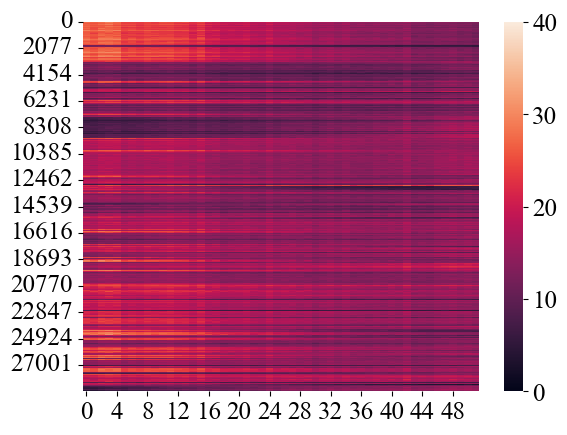

In [315]:
trash_subcarriers = [0,1,2,3,4,5,32,59,60,61,62,63]
useful_subcarriers = [k for k in range(64) if k not in trash_subcarriers]

sns.heatmap(amp[:, useful_subcarriers])

In [284]:
from mpl_toolkits.mplot3d import Axes3D

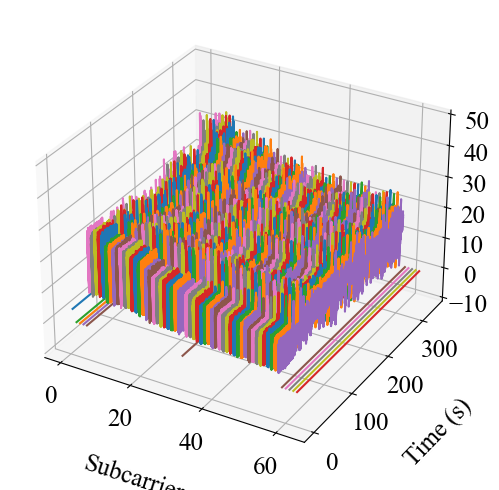

In [320]:
t = np.array(timestamp)-timestamp[0]
num_frames, num_subcarriers = amp.shape

# 3Dプロットの設定
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# 各サブキャリアの時系列データをプロット
for i in range(num_subcarriers):
    ax.plot([i]*num_frames, t, amp[:, i], label=f'SC {i}')

# 軸ラベルを離して配置
ax.set_xlabel('Subcarrier', labelpad=20)
ax.set_ylabel('Time (s)', labelpad=20)
ax.set_zlabel('Amplitude', labelpad=20)

ax.set_zlim(-10, 50)

# ax.set_title('Time Series of CSI Amplitudes')
# plt.savefig('./plot/time_series_of_csi.pdf', bbox_inches='tight')
plt.show()

In [326]:
target_fps = 100
real_resampled = linear_interpolate_resampling(real, timestamp, start_time_jst.timestamp(), end_time_jst.timestamp(), target_fps)
imag_resampled = linear_interpolate_resampling(imag, timestamp, start_time_jst.timestamp(), end_time_jst.timestamp(), target_fps)
amp_resampled = linear_interpolate_resampling(amp, timestamp, start_time_jst.timestamp(), end_time_jst.timestamp(), target_fps)
phase_resampled = linear_interpolate_resampling(phase, timestamp, start_time_jst.timestamp(), end_time_jst.timestamp(), target_fps)

# Ampの観察

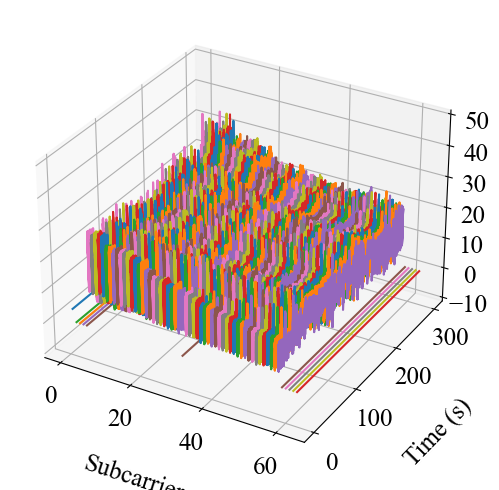

In [327]:
num_frames, num_subcarriers = amp_resampled.shape
fs = 100
t = np.arange(0, num_frames) / fs  # 時間ベクトル

# 3Dプロットの設定
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# 各サブキャリアの時系列データをプロット
for i in range(num_subcarriers):
    ax.plot([i]*num_frames, t, amp_resampled[:, i], label=f'SC {i}')

# 軸ラベルを離して配置
ax.set_xlabel('Subcarrier', labelpad=20)
ax.set_ylabel('Time (s)', labelpad=20)
ax.set_zlabel('Amplitude', labelpad=20)

ax.set_zlim(-10, 50)

# ax.set_title('Time Series of CSI Amplitudes')
# plt.savefig('./plot/time_series_of_csi.pdf', bbox_inches='tight')
plt.show()

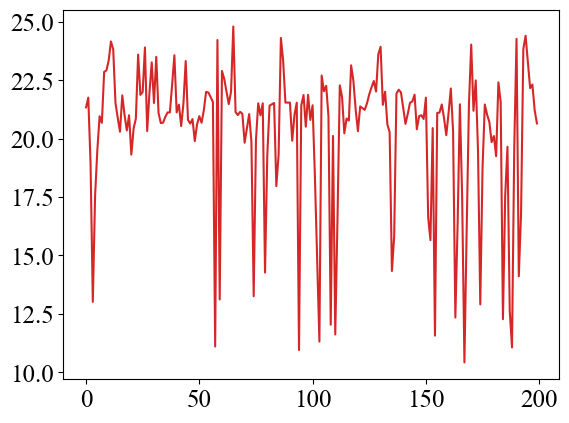

In [328]:
plt.plot(amp_resampled[100:300, 20])

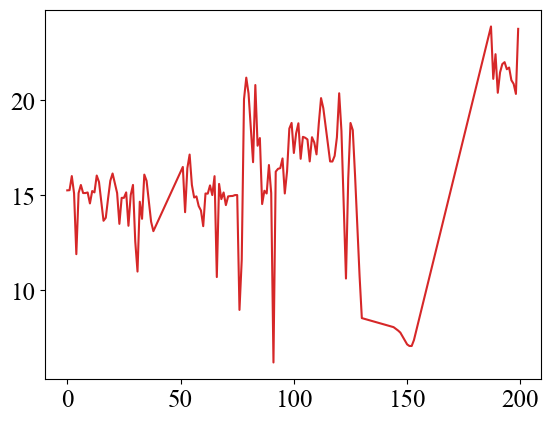

In [329]:
plt.plot(amp_filtered[100:300, 20])

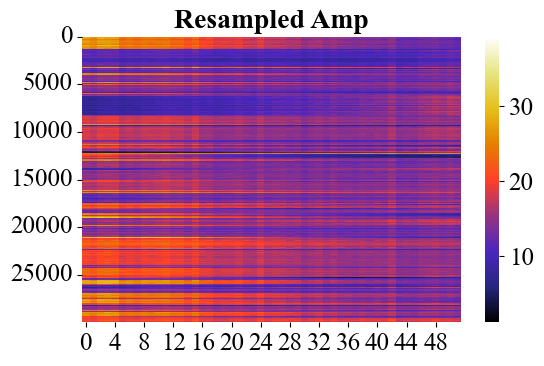

In [343]:
plot_csi(amp_resampled[:, useful_subcarriers], 'Resampled Amp')

In [243]:
from util.plot.heatmap import plot_csi
from util.preprocess.csi.denoising import hampel_filter
from util.preprocess.csi.normalize import normalize_csi_amplitudes_by_frame_power, normalize_csi_amplitudes_by_frame_mean
from util.preprocess.csi.phase import remove_timing_offset

In [332]:
amp_filtered = hampel_filter(amp_resampled[:, useful_subcarriers], window_size=100, n_sigmas=3)

Output()

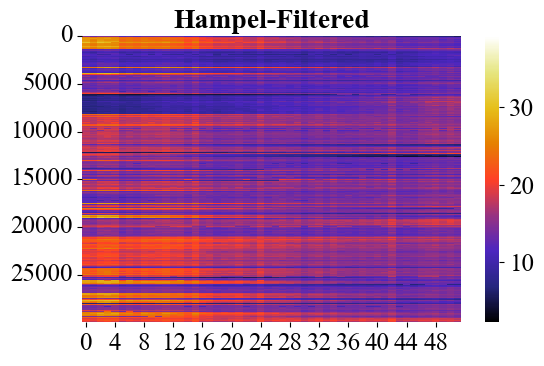

In [334]:
plot_csi(amp_filtered, 'Hampel-Filtered')

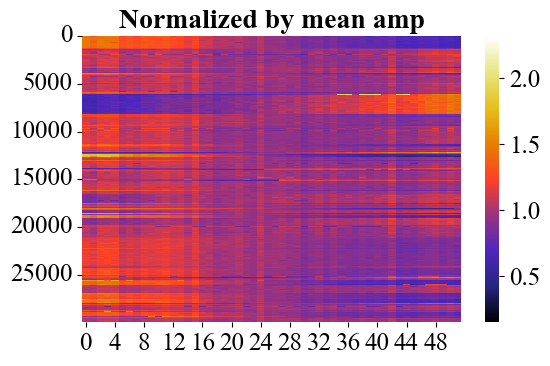

In [339]:
amp_normalized_m = normalize_csi_amplitudes_by_frame_mean(amp_filtered)
plot_csi(amp_normalized_m, 'Normalized by mean amp')

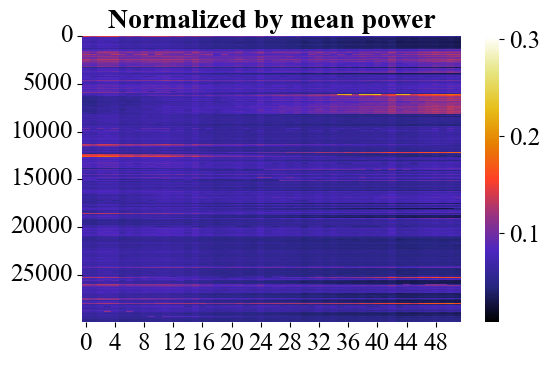

In [340]:
amp_normalized_p = normalize_csi_amplitudes_by_frame_power(amp_filtered)
plot_csi(amp_normalized_p, 'Normalized by mean power')

In [344]:
def windowing(data, window_size):
    # スライディングウィンドウを適用して、(N, window_size, features)の形に変換
    shape = (data.shape[0] // window_size, window_size, data.shape[1])
    return data[:shape[0] * window_size].reshape(shape)

In [347]:
windowed_amp = windowing(amp_normalized_m, 10)

In [348]:
windowed_amp.shape

(3000, 10, 52)

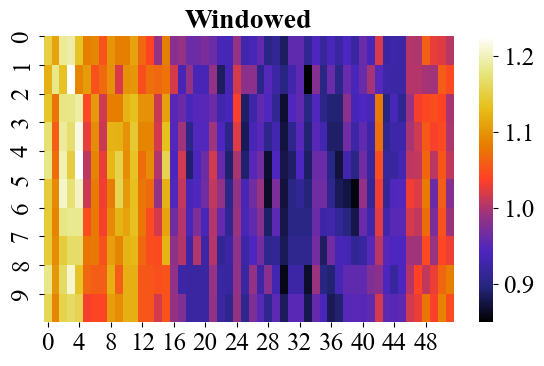

In [360]:
n = 1000
plot_csi(windowed_amp[n,:,:], 'Windowed')

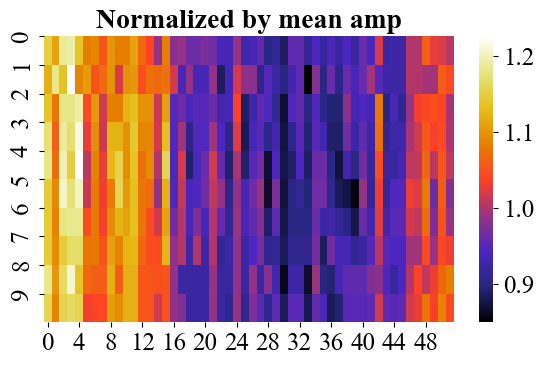

In [361]:
plot_csi(amp_normalized_m[n*10:(n+1)*10,:], 'Normalized by mean amp')

# Real and Imag

In [362]:
real_resampled.shape

(30000, 64)

In [363]:
imag_resampled.shape

(30000, 64)

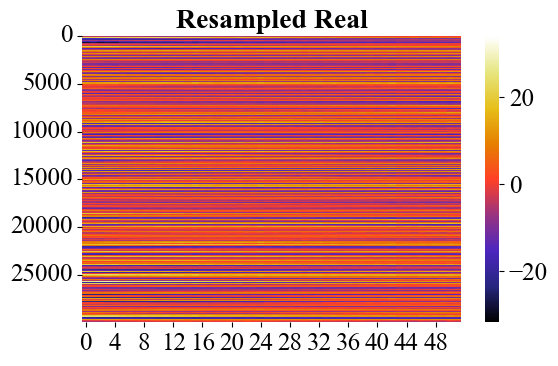

In [373]:
plot_csi(real_resampled[:, useful_subcarriers], 'Resampled Real')

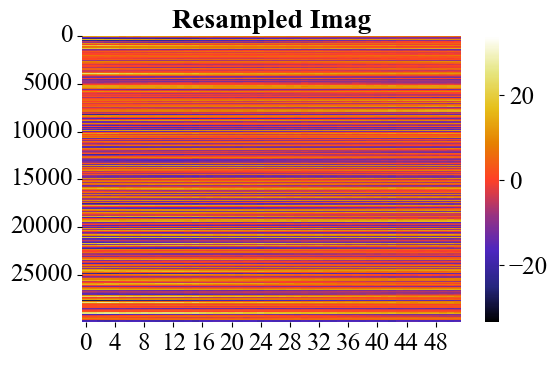

In [374]:
plot_csi(imag_resampled[:, useful_subcarriers], 'Resampled Imag')

In [369]:
real_filtered = hampel_filter(real_resampled[:, useful_subcarriers])
imag_filtered = hampel_filter(imag_resampled[:, useful_subcarriers])

Output()

Output()

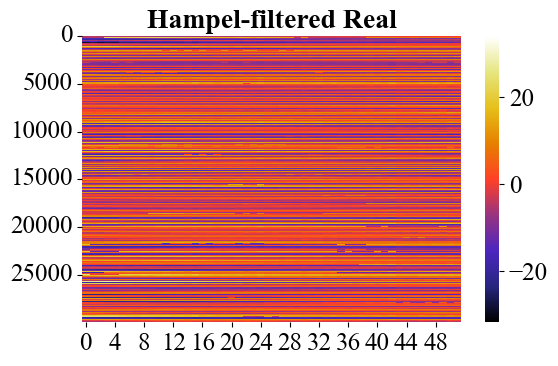

In [370]:
plot_csi(real_filtered, 'Hampel-filtered Real')

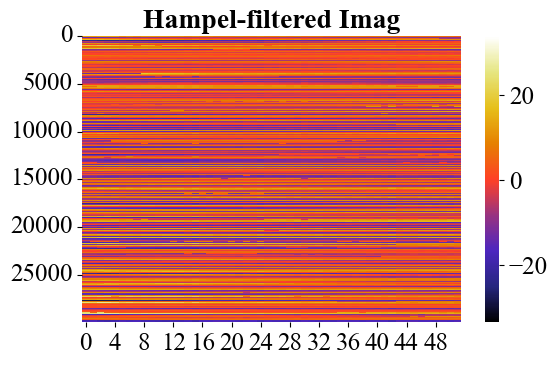

In [371]:
plot_csi(imag_filtered, 'Hampel-filtered Imag')

In [380]:
from util.preprocess.csi.normalize import normalize_csi_data_by_frame_power, normalize_csi_data_by_frame_mean

In [375]:
csi = np.stack([real_filtered, imag_filtered], axis=-1)
csi_not_filtered = np.stack([real_resampled[:, useful_subcarriers], imag_resampled[:, useful_subcarriers]], axis=-1)

In [392]:
normalized_csi_p = normalize_csi_data_by_frame_power(csi)
normalized_csi_m = normalize_csi_data_by_frame_mean(csi)

normalized_csi_nf_p = normalize_csi_data_by_frame_power(csi_not_filtered)
normalized_csi_nf_m = normalize_csi_data_by_frame_mean(csi_not_filtered)

In [393]:
normalized_csi_p.shape

(30000, 52, 2)

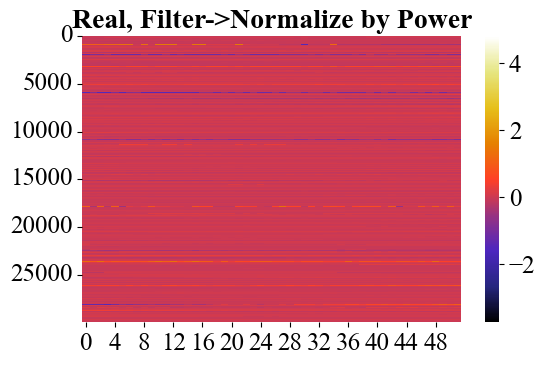

In [394]:
plot_csi(normalized_csi_p[:, :, 0], 'Real, Filter->Normalize by Power')

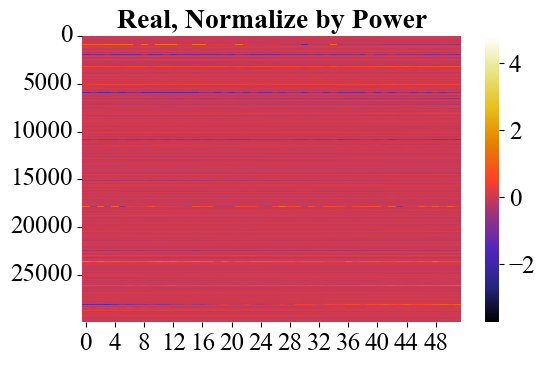

In [395]:
plot_csi(normalized_csi_nf_p[:, :, 0], 'Real, Normalize by Power')

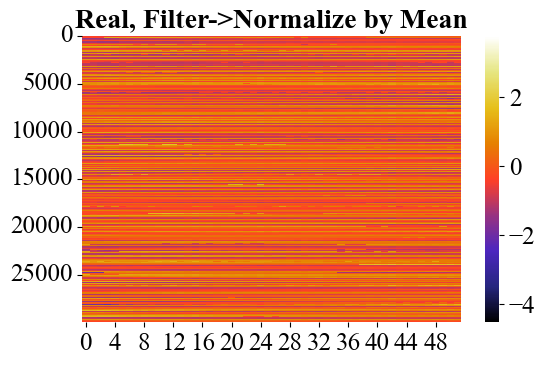

In [396]:
plot_csi(normalized_csi_m[:, :, 0], 'Real, Filter->Normalize by Mean')

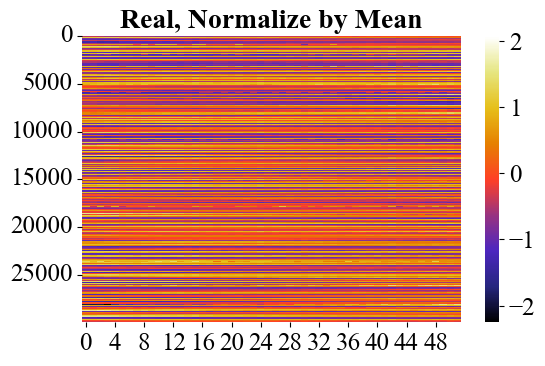

In [397]:
plot_csi(normalized_csi_nf_m[:, :, 0], 'Real, Normalize by Mean')